# Exercise 2
Consider the grid-world shown in the below figure. In each (non-grey) cell, it is possible to perform five actions: move up, down, left, right, or do nothing, as long as the resulting move stays inside the grid world. Grey cells are obstacles and are not allowed. We would like to find the optimal value function and optimal policy that minimize the following cost:

$$
\min \sum_{n=0}^{\infty} \alpha^n g_n(x_n)
$$

with discount factor $ \alpha = 0.99 $ and where the instantaneous cost is defined as:

$$
g_n(x_n) = 
\begin{cases}
-1 & \text{if } x_n \text{ is a violet cell} \\
0 & \text{if } x_n \text{ is a white cell} \\
1 & \text{if } x_n \text{ is a green cell} \\
10 & \text{if } x_n \text{ is a red cell}
\end{cases}
$$

In a Jupyter notebook, answer the following questions:

**(a)** Implement the value iteration algorithm to solve the problem (initialize the value function to 0). How many iterations does it take to attain convergence? (We assume here that convergence happens when all the elements of the value function do not change more than $ 10^{-6} $ in a new iteration).

**(b)** Implement the policy iteration algorithm to solve the problem (use the version that solves the linear equation $ (I - \alpha A) J_\mu = \bar{g} $ ). Start with an initial policy that does not move. How many iterations does it take to converge?

**(c)** Compare the solutions and convergence/complexity of each algorithm to solve this problem.

![Grid World](img/gridWorld.png)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

iterations = 10000
tol = 1e-6
alpha = 0.99

Grid = np.array([[0,      0,      1,  0, -1],
                 [0, np.nan,      1,  0, 10],
                 [0,     10, np.nan,  1,  0],
                 [1,      0,      0, 10, -1]])





In [2]:
# Initialize the Class for the Grid
class GridWorld:
    def __init__(self, Grid, alpha=0.99, tol=1e-6):
        self.Grid = Grid
        self.alpha = alpha
        self.tol = tol
        self.rows, self.cols = Grid.shape

    def valid_move(self, x, y):
        return 0 <= x < self.rows and 0 <= y < self.cols and not np.isnan(self.Grid[x, y])
    
    def move_neighbors(self, x, y):
        neighbors = []
        if self.valid_move(x-1, y):
            neighbors.append((x-1, y))
        if self.valid_move(x+1, y): 
            neighbors.append((x+1, y))
        if self.valid_move(x, y-1):
            neighbors.append((x, y-1))
        if self.valid_move(x, y+1):
            neighbors.append((x, y+1))
        return neighbors
    
    # Define a function to plot the results
    def plot_results(self, Grid, norm_list, tol_list):
        plt.figure(figsize=(5, 5), layout="tight")
        plt.imshow(Grid, cmap='viridis')
        plt.title("Grid")
        plt.figure(figsize=(10, 5), layout="tight")
        plt.subplot(2, 1, 1)
        plt.plot(norm_list)
        plt.xlabel("Index")
        plt.ylabel("Norm of the cost")
        plt.title("Convergence of Value Iteration")
        plt.subplot(2, 1, 2)
        plt.plot(tol_list)
        plt.xlabel("Index")
        plt.ylabel("Tolerance")
        plt.title("Tolerance")
        plt.show()
        return None
    
class Value_Iteration(GridWorld):
    def __init__(self, Grid, alpha=0.99, tol=1e-6, iterations=10000):
        super().__init__(Grid, alpha, tol)
        self.iterations = iterations
        self.J_prime = np.zeros((iterations+1, self.rows, self.cols), dtype=float)
        self.J_prime[0] = Grid
        self.norm_list = []
        self.tol_list = []

    def value_iteration(self):
        for i in range(iterations):
            for state in range(self.Grid.size):
                ax, ay = np.unravel_index(state, self.Grid.shape)
                if np.isnan(self.Grid[ax, ay]):
                    self.J_prime[i, ax, ay] = np.nan
                    continue
                J_curr = self.J_prime[i, ax, ay]
                action_up = action_down = action_left = action_right = 0

                # Check the action and calculate the cost
                for x, y in self.move_neighbors(ax, ay):
                    if x < ax:
                        action_up = self.J_prime[i, x, y]
                    elif x > ax:
                        action_down = self.J_prime[i, x, y]
                    elif y < ay:
                        action_left = self.J_prime[i, x, y]
                    elif y > ay:
                        action_right = self.J_prime[i, x, y]
                
                # Determine the minimum cost among the possible actions
                J_opt = np.inf
                J_opt = np.nanmin([J_curr, action_up, action_down, action_left, action_right])

                # Update the cost-to-go function
                self.J_prime[i+1, ax, ay] = self.Grid[ax, ay] + self.alpha * J_opt

            # Calculate the norm of the cost-to-go function
            norm = np.sqrt(np.nansum(self.J_prime[i] ** 2))
            self.norm_list.append(norm)

            if i != 0:
                current_tol = np.abs(self.norm_list[i] - self.norm_list[i-1])
                self.tol_list.append(current_tol)
                if current_tol < self.tol:
                    print(f"Converged after {i+1} iterations. Final cost-to-go -\n{self.J_prime[i]}")
                    break
        return self.J_prime[i], self.norm_list, self.tol_list
        
        

Converged after 1520 iterations. Final cost-to-go -
[[-95.0794778  -96.0398768  -97.0099768  -98.9999768  -99.9999768 ]
 [-94.12868279          nan -96.0298768  -98.0099768  -88.9999768 ]
 [-93.18739573 -82.25552154          nan -97.0099768  -98.9999768 ]
 [-91.25552154 -90.34296609 -89.4395362  -88.9999768  -99.9999768 ]]


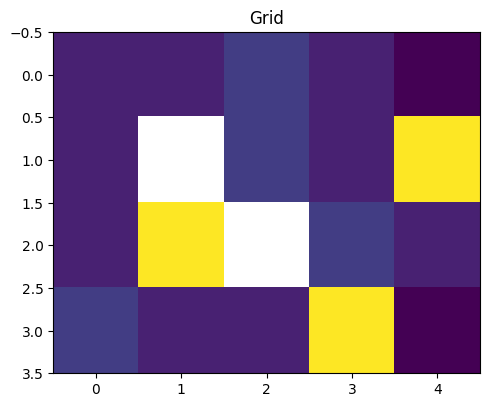

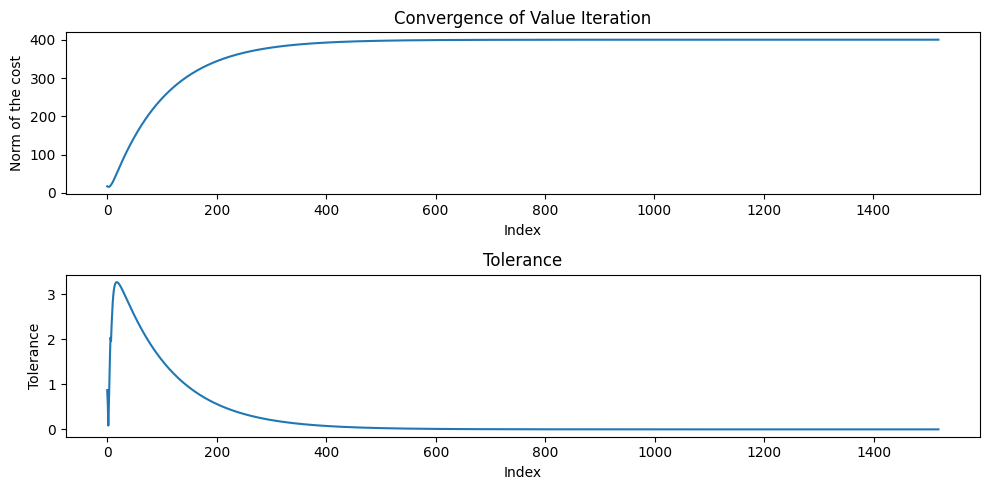

In [3]:
# Call the Value Iteration Class
val_start = time.time()
VI = Value_Iteration(Grid, alpha=alpha, tol=tol, iterations=iterations)
val_stop = time.time()
J_prime, norm_list, tol_list = VI.value_iteration()

# Plot the results
VI.plot_results(Grid, norm_list, tol_list)
# print(f"Time taken for Value Iteration: {val_stop - val_start} seconds")




In [4]:
class Policy_Determination(GridWorld):
    def __init__(self, Grid, J_prime):
        super().__init__(Grid)
        self.J_prime = J_prime
        self.policy = np.full(J_prime.shape, 'Obstacle', dtype=object)

    def determine_policy(self):
        for state in range(self.J_prime.size):
            ax, ay = np.unravel_index(state, self.J_prime.shape)
            if np.isnan(self.J_prime[ax, ay]):
                continue
            J_curr = self.J_prime[ax, ay]

            action_up = action_down = action_left = action_right = np.inf

            # Check each action and calculate the cost
            for x, y in self.move_neighbors(ax, ay):
                if x < ax:
                    action_up = self.J_prime[x, y]
                elif x > ax:
                    action_down = self.J_prime[x, y]
                elif y < ay:
                    action_left = self.J_prime[x, y]
                elif y > ay:
                    action_right = self.J_prime[x, y]
            
            J_min = np.inf
            optimal_action = 'Stay'
            if J_curr < J_min and not np.isnan(J_curr):
                J_min = J_curr
                optimal_action = 'Stay'
            if action_up < J_min and not np.isnan(action_up):
                J_min = action_up
                optimal_action = 'Up'
            if action_down < J_min and not np.isnan(action_down):
                J_min = action_down
                optimal_action = 'Down'
            if action_left < J_min and not np.isnan(action_left):
                J_min = action_left
                optimal_action = 'Left'
            if action_right < J_min and not np.isnan(action_right):
                J_min = action_right
                optimal_action = 'Right'
            self.policy[ax, ay] = optimal_action
        return self.policy
    
# Call the Policy Determination Class
PD = Policy_Determination(Grid, J_prime)
policy = PD.determine_policy()
print(policy)


[['Right' 'Right' 'Right' 'Right' 'Stay']
 ['Up' 'Obstacle' 'Right' 'Up' 'Up']
 ['Up' 'Left' 'Obstacle' 'Right' 'Down']
 ['Up' 'Left' 'Left' 'Right' 'Stay']]


# Part b

Converged in 11 iterations. Final cost-to-go -
[[ -95.079501    -96.0399      -97.01        -99.         -100.        ]
 [ -94.12870599           nan  -96.0299      -98.01        -89.        ]
 [ -93.18741893  -82.25554474           nan  -97.01        -99.        ]
 [ -91.25554474  -90.34298929  -89.4395594   -89.         -100.        ]]


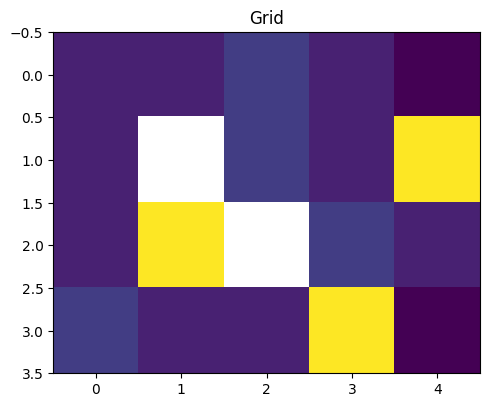

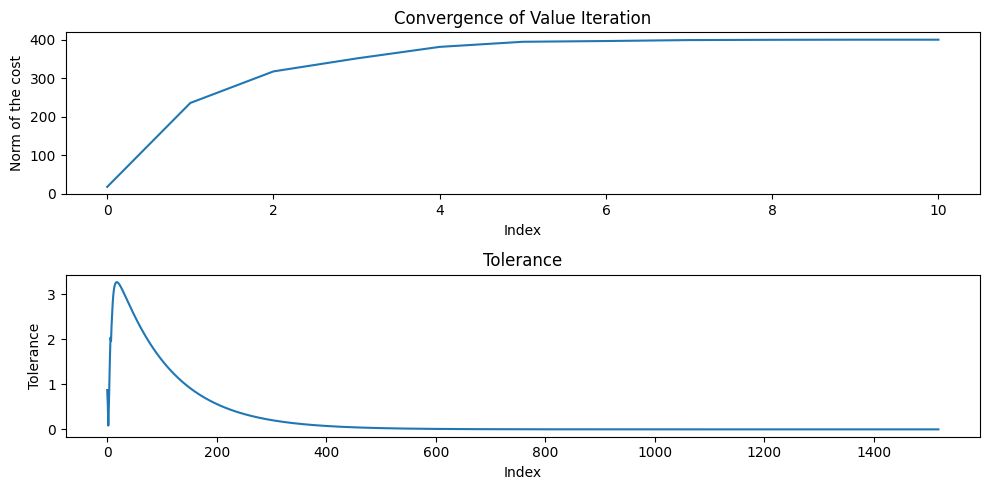

In [5]:
# Initialize the Class for Policy Iteration
class Policy_Iteration(GridWorld):
    def __init__(self, Grid, alpha=0.99, tol=1e-6):
        super().__init__(Grid, alpha, tol)
        self.rows, self.cols = Grid.shape
        self.norm_list = []
        self.obstacles = np.zeros((Grid.shape[0] * Grid.shape[1]))
        self.obstacles[6] = self.obstacles[12] = 1
        self.A = np.zeros((18,18))
        self.I = np.eye(18)

    def valid_move(self, x, y):
        return 0 <= x < self.rows and 0 <= y < self.cols and not np.isnan(self.Grid[x, y])
    
    def move_neighbors(self, x, y):
        neighbors = []
        if self.valid_move(x-1, y):
            neighbors.append((x-1, y))
        if self.valid_move(x+1, y): 
            neighbors.append((x+1, y))
        if self.valid_move(x, y-1):
            neighbors.append((x, y-1))
        if self.valid_move(x, y+1):
            neighbors.append((x, y+1))
        return neighbors

    def policy_iteration(self, iterations=1000):
        for i in range(iterations):
            try:
                J_u = np.linalg.solve(self.I - (self.alpha * self.A), np.delete(self.Grid, [6, 12]).reshape(-1,1))
            except np.linalg.LinAlgError:
                print("Singular matrix")
                break
            # insert back the obstacles
            J_u = np.insert(J_u, 6, np.nan)
            J_u = np.insert(J_u, 12, np.nan)
            J_u = J_u.reshape(4,5)
            norm = np.sqrt(np.nansum(J_u ** 2))
            self.norm_list.append(norm)

            if i != 0 and ((np.abs(self.norm_list[i] - self.norm_list[i-1])) < self.tol):
                break

            self.A = np.zeros((18,18))
            enumerate_A = enumerate(iter(self.A))
            for state in range(self.Grid.size):
                ax, ay = np.unravel_index(state, self.Grid.shape)
                if np.isnan(self.Grid[ax, ay]):
                    continue

                row, col = next(enumerate_A, (None, None))
                J_curr = J_u[ax, ay]
                action_up = np.inf
                action_down = np.inf
                action_left = np.inf
                action_right = np.inf

                # Check if the actions are possible and calculate the cost
                for x, y in self.move_neighbors(ax, ay):
                    if x < ax:
                        action_up = J_u[x, y]
                    elif x > ax:
                        action_down = J_u[x, y]
                    elif y < ay:
                        action_left = J_u[x, y]
                    elif y > ay:
                        action_right = J_u[x, y]
                
                J_min = np.inf
                optimal_action = ''
                if J_curr < J_min and not np.isnan(J_curr):
                    J_min = J_curr
                    optimal_action = 'Stay'
                if action_up < J_min and not np.isnan(action_up):
                    J_min = action_up
                    optimal_action = 'Up'
                if action_down < J_min and not np.isnan(action_down):
                    J_min = action_down
                    optimal_action = 'Down'
                if action_left < J_min and not np.isnan(action_left):
                    J_min = action_left
                    optimal_action = 'Left'
                if action_right < J_min and not np.isnan(action_right):
                    J_min = action_right
                    optimal_action = 'Right'
                
                # Create a placeholder for the action
                action = np.zeros((self.Grid.shape))
                if optimal_action == 'Stay':
                    action[ax, ay] = 1
                elif optimal_action == 'Up':
                    action[ax-1, ay] = 1
                elif optimal_action == 'Down':
                    action[ax+1, ay] = 1
                elif optimal_action == 'Left':
                    action[ax, ay-1] = 1
                elif optimal_action == 'Right':
                    action[ax, ay+1] = 1
                
                # Update the row of A
                self.A[row] = np.delete(action, [6, 12]).reshape(1,-1)
        print(f"Converged in {i+1} iterations. Final cost-to-go -\n{J_u}")
        self.norm_list = np.array(self.norm_list[:i+1])
        return J_u, self.norm_list
    
# Call the Policy Iteration Class
policy_start = time.time()
PI = Policy_Iteration(Grid, alpha=alpha, tol=tol)
policy_stop = time.time()
J_u, norm_list = PI.policy_iteration()
# Plot the results using plot_results function
PI.plot_results(Grid, norm_list, tol_list)
# print(f"Time taken for Policy Iteration: {policy_stop - policy_start} seconds")


In [7]:
# Determine the final Policy
PD_New = Policy_Determination(Grid, J_u)
policy_new = PD_New.determine_policy()
print(policy_new)

[['Right' 'Right' 'Right' 'Right' 'Stay']
 ['Up' 'Obstacle' 'Right' 'Up' 'Up']
 ['Up' 'Left' 'Obstacle' 'Right' 'Down']
 ['Up' 'Left' 'Left' 'Right' 'Stay']]


In [6]:
# Compare the time taken for both the algorithms
print(f"Time taken for Value Iteration: {val_stop - val_start} seconds")
print(f"Time taken for Policy Iteration: {policy_stop - policy_start} seconds")

Time taken for Value Iteration: 0.0003781318664550781 seconds
Time taken for Policy Iteration: 0.00013208389282226562 seconds
